In [2]:

from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Lambda(lambda x: x.to(device))
])

In [4]:
trn_ds = MNIST('/content/', transform = img_transform, train = True, download = True)
val_ds = MNIST('/content/', transform = img_transform, train = False, download = True)

In [5]:
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28*28),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(len(x), -1)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(len(x), 1, 28, 28)

        return x


In [6]:
def train_batch(input, model, crit, opt):
    model.train()
    opt.zero_grad()
    output = model(input)
    loss = crit(output, input)
    loss.backward()
    opt.step()

    return loss

@torch.no_grad()
def validate_batch(input, model, crit):
    model.eval()
    output = model(input)
    loss = crit(output, input)

    return loss

c:\Users\kaiqu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1, 28, 28])) that is different to the input size (torch.Size([1, 1, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


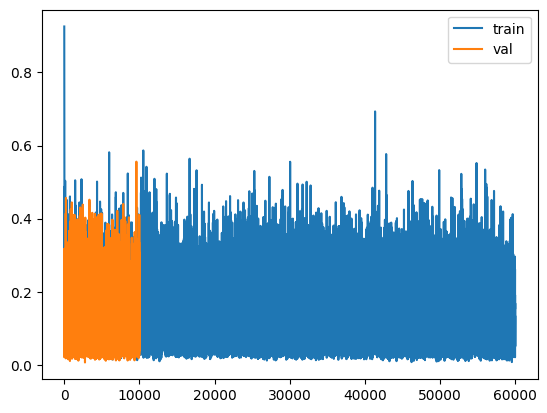

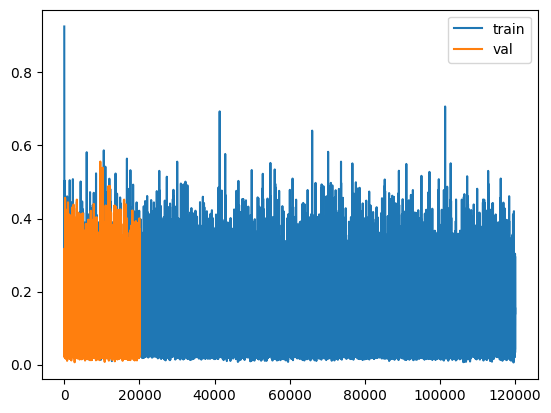

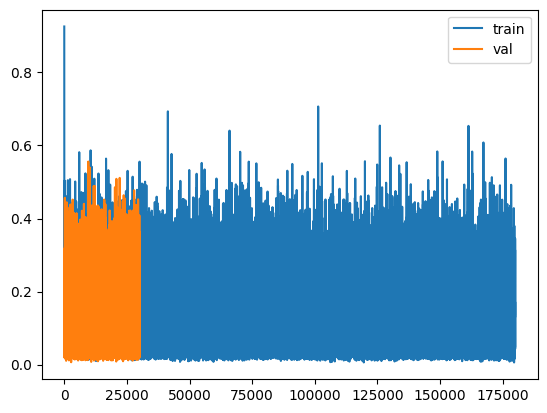

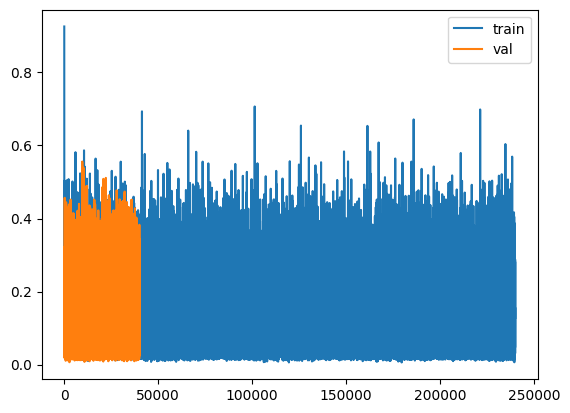

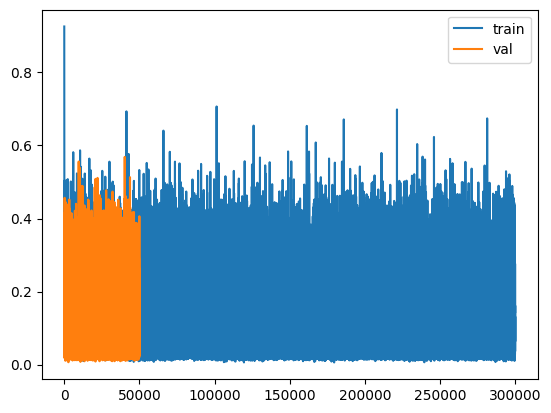

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

model = AutoEncoder(3).to(device)
crit = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

epochs = 5

# listas pra guardar os valores pois o Report nao funciona
train_losses = []
val_losses = []

# esse loop roda o modelo e plota os gráficos
for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0

    # treinamento
    for ix, (data, _) in enumerate(trn_ds):
        loss = train_batch(data, model, crit, opt)
        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(trn_ds)
    train_losses.append(avg_train_loss)

    model.eval()
    epoch_val_loss = 0

    # validação
    for ix, (data, _) in enumerate(val_ds):
        loss = train_batch(data, model, crit, opt)
        epoch_val_loss += loss.item()

    avg_val_loss = epoch_val_loss / len(val_ds)
    val_losses.append(avg_val_loss)

plt.plot(train_losses, label = 'train')
plt.plot(val_losses, label = 'val')
plt.legend()
plt.show()